In [ ]:
import matplotlib
import matplotlib.pyplot as plt


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [ ]:
!pip uninstall torch
!pip install torch

Found existing installation: torch 2.5.0+cu121
Uninstalling torch-2.5.0+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.5.0+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? Y
ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0

<ipython-input-5-780f9f451008>:177: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  adversary_policy = lambda s0: f.softmax(params[s0])
<ipython-input-5-780f9f451008>:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  adversary_policy1 = lambda s1, o0, a0: f.softmax(params1[s1, o0, a0])
<ipython-input-5-780f9f451008>:226: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob1 = f.softmax(params[traj["obs"]])[traj["action"]]
<ipython-input-5-780f9f451008>:227: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob2 = th.squeeze(f.softmax(params1[traj["obs1"], traj["action"], traj["victim_action"]]))[traj["action1"]]


Streaming output truncated to the last 5000 lines.
         [[0.0049, 0.9951],
          [0.4468, 0.5532]]],


        [[[0.6114, 0.3886],
          [0.5939, 0.4061]],

         [[0.9797, 0.0203],
          [0.5423, 0.4577]]]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
lambda:  4708.908392958927
kl:  0.067640949984472
TEST REWARD MEAN:  -0.405
LOSS: 0.3473496217032405
params: tensor([[0.0022, 0.9978],
        [0.9955, 0.0045]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
params1: tensor([[[[0.4389, 0.5611],
          [0.3316, 0.6684]],

         [[0.0049, 0.9951],
          [0.4468, 0.5532]]],


        [[[0.6114, 0.3886],
          [0.5899, 0.4101]],

         [[0.9799, 0.0201],
          [0.5423, 0.4577]]]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
lambda:  4715.645163406483
kl:  0.06737531617282408
TEST REWARD MEAN:  -0.417
LOSS: 0.3743674251773435
params: tensor([[0.0022, 0.9978],
        [0.9956, 0.0044]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
params

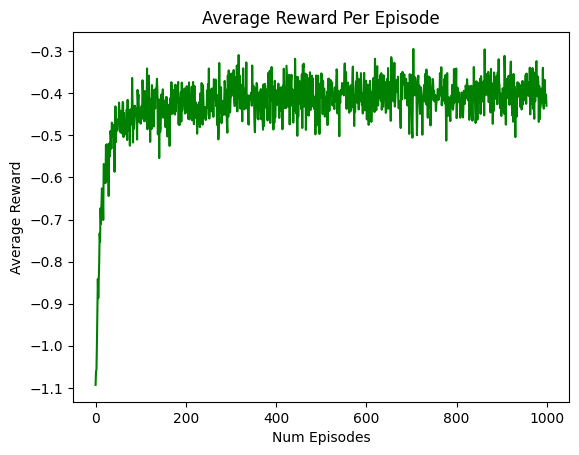

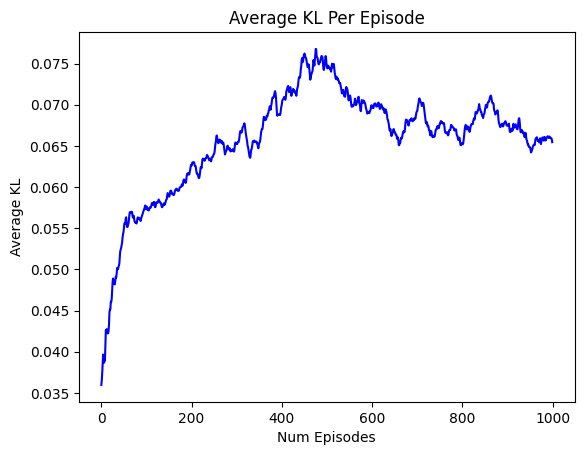

In [ ]:
from collections import defaultdict
import torch as th
import torch.nn.functional as f


import numpy as np


th.autograd.set_detect_anomaly(True)

# Construct the environment
## We have three different environment configurations:

class IlluToyMDP():

  def __init__(self, adversary_policy=None, adversary_policy1=None, victim_policy=None, victim_policy1 = None, mode="unattacked"):
    # 3 different modes: unattacked, attacked_adversary, attacked_victim
    self.step_ctr = 0
    self.set_mode(mode, adversary_policy, adversary_policy1, victim_policy, victim_policy1)
    self.reward_matrix = th.FloatTensor([[-1, 1],[1, 0.5]])  ## state x action
    self.prob_s0 = th.tensor([1/3., 2/3.], dtype=th.float)
    self.trans_prob = f.softmax(th.rand(2, 2, 2), dim=-1)
    pass

  def set_mode(self, mode, adversary_policy=None, adversary_policy1 = None, victim_policy=None, victim_policy1 = None):
    if mode == "attacked_adversary":
      assert victim_policy is not None, "Need a valid victim policy!"
    elif mode == "attacked_victim":
      assert adversary_policy is not None, "Need a valid adversary policy!"
    self.mode = mode
    self.adversary_policy = adversary_policy
    self.victim_policy = victim_policy
    self.adversary_policy1 = adversary_policy1
    self.victim_policy1 = victim_policy1

  def step(self, action, victim_a0=None, action1=None):
    info = {}
    if self.step_ctr == 0:
      if self.mode == "unattacked":
        reward = self.reward_matrix[self.state, action].item()
        self.state = th.multinomial(self.trans_prob[self.state, action_v], 1)
      elif self.mode == "attacked_adversary":
        action_v = th.multinomial(self.victim_policy(action), 1)
        reward = -self.reward_matrix[self.state, action_v].item()
        info["victim_action"] = action_v
        self.state = th.multinomial(self.trans_prob[self.state, action_v], 1)
        self.obs = self.state
      elif self.mode == "attacked_victim":
        reward = self.reward_matrix[self.state, action].item()
        self.obs = self.adversary_policy(self.state)
        self.state = th.multinomial(self.trans_prob[self.state, action_v], 1)
      obs = self.obs
      done = False
      terminated = False
      return obs, reward, done, terminated, info
    elif self.step_ctr == 1:
      if self.mode == "unattacked":
        reward = self.reward_matrix[self.state, action].item()
      elif self.mode == "attacked_adversary":
        action_v1 = th.multinomial(self.victim_policy1(action, action1, victim_a0), 1) # add additional terms (ao ans Oo)
        reward = -self.reward_matrix[self.state, action_v1].item()
        info["victim_action"] = action_v1
        #self.state = th.multinomial(self.trans_prob[self.state, action_v1], 1) # check this
        self.obs = self.state# check this
      elif self.mode == "attacked_victim":
        reward = self.reward_matrix[self.state, action].item()
      obs = self.obs
      done = True
      terminated = False
      self.step_ctr = 2
      return obs, reward, done, terminated, info

  def reset(self):
    self.step_ctr = 0
    self.state = th.multinomial(self.prob_s0, 1)
    if self.mode == "unattacked":
      self.obs = self.state
    elif self.mode == "attacked_adversary":
      self.obs = self.state
    elif self.mode == "attacked_victim":
      self.obs = self.adversary_policy(self.state) # step = 0 was here
    return self.obs

  def exact_kl(self,
               order,
               adversary_policy,
               adversary_policy1,
               victim_policy,
               victim_policy1):
    assert order in ["attacked|unattacked", "unattacked|attacked"]
    action_space = list(range(self.reward_matrix.shape[1]))
    obs_space = list(range(self.reward_matrix.shape[0]))
    state_space = obs_space
    exact_kls = []

    if True:
      for o in obs_space:
        o = th.tensor(o)
        for a in action_space:
          a = th.tensor(a)
          for o1 in obs_space:
            o1 = th.tensor(o1)
            for a1 in action_space:
              a1 = th.tensor(a1)
              P_a = 0
             # calculate P_a(tau_o) = P_a(o, a) = int_s pi_a(o|s)p(s)pi_v(a|o) *
              for s in state_space:
                s = th.tensor(s)
                for s1 in state_space:
                  s1 = th.tensor(s1)
                  P_a += self.prob_s0[s] * adversary_policy(s)[o] * victim_policy(o)[a] * self.trans_prob[s, a][s1] * adversary_policy1(s1, o, a)[o1] * victim_policy1(o, o1, a)[a1]
              P = self.prob_s0[o] * victim_policy(o)[a] * self.trans_prob[o, a][o1] * victim_policy1(o, o1, a)[a1]
              if order == "attacked|unattacked":
                if not(P_a.item() == 0.0 == P.item()):
                  contrib = P_a.clone() * (th.log(P_a.clone()) - th.log(P.clone()))
                  exact_kls.append(contrib)
              else:
                if not(P_a.item() == 0.0 == P.item()):
                  contrib = P.clone() * (th.log(P.clone()) - th.log(P_a.clone()))
                  exact_kls.append(contrib)
    mean_kl = th.mean(th.cat([ek.reshape(1) for ek in exact_kls]))
    if th.isnan(mean_kl).item() or mean_kl.item() < 0.0:
        assert False, "FATAL"
    return mean_kl


def victim_policy_func(obs, obs1, a):
  if obs.item() == 0 and a.item() == 0 and obs1 == 0:
    return th.tensor([0.0, 1.0], dtype=th.float)
  elif obs.item() == 0 and a.item() == 0 and obs1 == 1:
    return th.tensor([1.0, 0.0], dtype=th.float)
  elif obs.item() == 1 and a.item() == 0 and obs1 == 0:
    return th.tensor([0.0, 1.0], dtype=th.float)
  elif obs.item() == 1 and a.item() == 0 and obs1 == 1:
    return th.tensor([1.0, 0.0], dtype=th.float)
  elif obs.item() == 0 and a.item() == 1 and obs1 == 0:
    return th.tensor([0.0, 1.0], dtype=th.float)
  elif obs.item() == 0 and a.item() == 1 and obs1 == 1:
    return th.tensor([0.0, 1.0], dtype=th.float)
  else:
    return th.tensor([0.0, 1.0], dtype=th.float)


def victim_policy_func1(obs, obs1, a):
  if obs.item() == 0 and a.item() == 0 and obs1 == 0:
    return th.tensor([0.25, 75], dtype=th.float)
  elif obs.item() == 0 and a.item() == 0 and obs1 == 1:
    return th.tensor([0.65, 0.35], dtype=th.float)
  elif obs.item() == 1 and a.item() == 0 and obs1 == 0:
    return th.tensor([0.35, 0.65], dtype=th.float)
  elif obs.item() == 1 and a.item() == 0 and obs1 == 1:
    return th.tensor([0.2, 0.8], dtype=th.float)
  elif obs.item() == 0 and a.item() == 1 and obs1 == 0:
    return th.tensor([0.35, 0.65], dtype=th.float)
  elif obs.item() == 0 and a.item() == 1 and obs1 == 1:
    return th.tensor([0.2, 0.8], dtype=th.float)
  else:
    return th.tensor([0.25, 0.75], dtype=th.float)




def exact_dist():
    # Find optimal adversary policy with REINFORCE (with exact distributional constraints)
    env = IlluToyMDP()
    n_states = 2
    n_actions = 2
    params = th.nn.Parameter(th.zeros(n_states, n_states).uniform_().double(), requires_grad=True)
    params1 = th.nn.Parameter(th.zeros(n_states, n_states, n_actions, n_states).uniform_().double(), requires_grad=True)
    n_rollout_steps = 100
    n_rollout_steps_eval = 1000
    n_updates = 10
    n_episodes = 1000
    alpha = 5*10E-3
    alpha_lambda = 10.0
    lmbda = 1.0  # arbitrary!
    adversary_policy = lambda s0: f.softmax(params[s0])
    adversary_policy1 = lambda s1, o0, a0: f.softmax(params1[s1, o0, a0])
    #victim_policy = lambda obs: th.tensor([0.5, 0.5], dtype=th.float) if obs.item() == 0 else th.tensor([0.4, 0.6], dtype=th.float)
    victim_policy1 = lambda o0, o1, a0: victim_policy_func(o0, o1, a0)
    victim_policy = lambda o0:th.tensor([0.0, 1.0], dtype=th.float) if o0.item() == 0 else th.tensor([1.0, 0.0], dtype=th.float)
    #victim_policy1 = lambda o0, o1, a0:th.tensor([0.0, 1.0], dtype=th.float) if o1.item() == 0 else th.tensor([1.0, 0.0], dtype=th.float)

    env.set_mode("attacked_adversary", adversary_policy = adversary_policy, adversary_policy1 = adversary_policy1, victim_policy=victim_policy, victim_policy1 = victim_policy1)
    done = False
    obs = env.reset()
    trajectories = [defaultdict(lambda: {})]
    trajectories[-1]["obs"] = obs.item()
    mean_reward_list = []
    loss_list = []
    kl_list = []
    for i in range(n_episodes):
        trajectories[-1]["obs"] = obs.item()
        # rollout phase
        for j in range(n_rollout_steps):
            action = th.multinomial(adversary_policy(obs), 1)
            obs1, reward, done, _, info = env.step(action)
            trajectories[-1]["reward"] = reward
            trajectories[-1]["action"] = action.item()
            trajectories[-1]["obs1"] = obs1.item()
            victim_action = info["victim_action"]
            trajectories[-1]["victim_action"] = victim_action
            action1 = th.multinomial(adversary_policy1(obs1.item(), action.item(), victim_action.item()), 1)
            env.step_ctr += 1
            _, reward1, done, _, info = env.step(action, victim_action, action1)
            trajectories[-1]["action1"] = action1.item()
            trajectories[-1]["reward1"] = reward1
            if done:
                obs = env.reset()
                trajectories.append(defaultdict(lambda: {}))
                trajectories[-1]["obs"] = obs.item()


        # train phase

        kl_exact_lst = []
        for j in range(n_updates):
            kl_exact = env.exact_kl("attacked|unattacked",
                                    adversary_policy = adversary_policy,
                                    adversary_policy1 = adversary_policy1,
                                    victim_policy=victim_policy,
                                    victim_policy1 = victim_policy1)
            loss = 0
            for n, traj in enumerate(trajectories[:-1]):
                try:
                    prob1 = f.softmax(params[traj["obs"]])[traj["action"]]
                    prob2 = th.squeeze(f.softmax(params1[traj["obs1"], traj["action"], traj["victim_action"]]))[traj["action1"]]
                    loss += ( (th.log(prob1) * traj["reward"]) + (th.log(prob2) * traj["reward1"]) ) # - lmbda * kl_exact
                    kl_exact_lst.append(kl_exact.detach().cpu().numpy())
                except:
                    #print("WARNING: loss addition failed")
                    pass

            loss /= len(trajectories)
            loss.backward()
            params.data += alpha * params.grad.data
            params.grad.zero_()

            params1.data += alpha * params1.grad.data
            params1.grad.zero_()

            # Now we do the dual ascent step
            with th.no_grad():
                kl_exact = env.exact_kl("attacked|unattacked",
                                        adversary_policy=adversary_policy,
                                        adversary_policy1 = adversary_policy1,
                                        victim_policy=victim_policy,
                                        victim_policy1=victim_policy1)

            lmbda = max(lmbda + alpha_lambda * kl_exact, 0)

        print("LOSS:", loss.item())
        loss_list.append(loss.item())
        print(f"params: {f.softmax(params, -1)}")
        print(f"params1: {f.softmax(params1, -1)}")
        print("lambda: ", lmbda.item())
        print("kl: ", np.mean(kl_exact_lst))
        kl_list.append(np.mean(kl_exact_lst))

        # evaluate
        reward_lst = []
        obs = env.reset()

        for j in range(n_rollout_steps_eval):
            action = th.multinomial(adversary_policy(obs), 1)
            obs1, reward, done, _, info = env.step(action)
            victim_action = info["victim_action"]
            action1 = th.multinomial(adversary_policy1(obs1.item(), action.item(), victim_action.item()), 1)
            env.step_ctr += 1
            _, reward1, done, _, info = env.step(action, victim_action, action1)
            tot_reward = reward + reward1
            reward_lst.append(tot_reward)
            if done:
                obs = env.reset()

        print("TEST REWARD MEAN: ", np.mean(reward_lst))
        mean_reward_list.append(np.mean(reward_lst))

        trajectories = [defaultdict(lambda: [])]

    print(kl_list)
    print("Reacher here")
    plt.plot(mean_reward_list, color="green")
    plt.title("Average Reward Per Episode")
    plt.ylabel("Average Reward")
    plt.xlabel("Num Episodes")
    plt.show()
    plt.plot(kl_list, color="blue")
    plt.title("Average KL Per Episode")
    plt.ylabel("Average KL")
    plt.xlabel("Num Episodes")
    plt.show()


if __name__ == "__main__":
	exact_dist()